<a href="https://colab.research.google.com/github/Alessandro1999/FreeKeystrokeDynamics/blob/main/Contrastive_Learning_for_Keystroke_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive learning for Keystroke Dynamics
by Alessandro Torri.


The purpose of this project is to train a Pytorch model with contrastive learning to obtain a feature representation of free-text keystroke dynamics, and then use this model to implement a verification system.
The idea of the project is strongly inspired by this [paper](https://arxiv.org/pdf/2004.03627.pdf), with the objective of improving their results.

##0. Environment setup

In [ ]:
#@title Downloading libraries
!pip -q install pytorch-lightning
!pip -q install wandb

In [ ]:
#@title Import libraries
# general libraries
import os
import re
from pathlib import Path
from typing import *
from google.colab import drive
import requests
from tqdm import tqdm
# ml libraries
import pandas as pd
import csv
from sklearn import model_selection
import math
import random
import torch
import pytorch_lightning as pl
from pytorch_lightning import callbacks
import wandb
# for scraping of js keycodes
from bs4 import BeautifulSoup
import json

seed = 17
pl.seed_everything(seed)

INFO:lightning_fabric.utilities.seed:Global seed set to 17


17

In [ ]:
#@title Hyperparameters
#@markdown Number of batches per epoch to consider
train_batches_per_epoch: int = 150 #@param{type: "integer"}
#@markdown Size of a batch
batch_size: int = 128 #@param{type: "integer"}
#@markdown Name of the Weights & Biases run
run_name: str = "Transformer(alpha2)" #@param{type : "string"}
#@markdown Number of subject in the training set
train_size : int = 68000 #@param{type: "integer"}
#@markdown Percentage of users of the training set to use for validation
perc: float = 0.000397 #@param{type: "number"}

##1. The dataset
The [dataset](https://userinterfaces.aalto.fi/136Mkeystrokes/) that will be used to train our model contains 15 sentences written by 168K different users with the modalities described in the following [paper](https://userinterfaces.aalto.fi/136Mkeystrokes/resources/chi-18-analysis.pdf).

The dataset consists of a .csv (tab separated) file for each user in which every line is a key typed event.
This representation wastes a lot of space and it also makes it more difficult to extrapolate a sequence from the dataframe.
For this reason, the first thing I did was to preprocess this dataset and format it such that it has a line for each sequence typed by the user.
This formatting operation reduced the size of the dataset from 16GB to 3GB and it makes it easier to be used.

However, considering the big size of the dataset, formatting it in python was really really slow, so I decided to do it using the Julia language and the code used to do that can be found in the following [notebook](https://colab.research.google.com/drive/1yrVAJRK3cgsgGTrXojRrs7v5Gfapffpf).

So, as a first thing to do, we will download and unzip our dataset from the public drive link where I uploaded it.

In [ ]:
#@title Download the dataset
!rm -rf sample_data
#!gdown "https://drive.google.com/uc?id=1yg8zcON6zyu90VCuEvVM8W9yg8Lk9olb"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yg8zcON6zyu90VCuEvVM8W9yg8Lk9olb' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1yg8zcON6zyu90VCuEvVM8W9yg8Lk9olb" -O Keystrokes_processed.zip && rm -rf /tmp/cookies.txt
!unzip -q Keystrokes_processed.zip
!rm Keystrokes_processed.zip

--2023-01-26 16:46:39--  https://docs.google.com/uc?export=download&confirm=t&id=1yg8zcON6zyu90VCuEvVM8W9yg8Lk9olb
Resolving docs.google.com (docs.google.com)... 108.177.127.139, 108.177.127.138, 108.177.127.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ndli3ed25f7910b5nluqvcrhtbkao4h7/1674751575000/05640747438315365327/*/1yg8zcON6zyu90VCuEvVM8W9yg8Lk9olb?e=download&uuid=68a82a80-bc8e-459b-93e4-635703b8e76f [following]
--2023-01-26 16:46:40--  https://doc-0g-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ndli3ed25f7910b5nluqvcrhtbkao4h7/1674751575000/05640747438315365327/*/1yg8zcON6zyu90VCuEvVM8W9yg8Lk9olb?e=download&uuid=68a82a80-bc8e-459b-93e4-635703b8e76f
Resolving doc-0g-cc-docs.googleusercontent.com (doc-0g-cc-docs.googleusercontent.com)... 142.251.31.1

### Data visualization
Now that we obtained the dataset, we can see how it is made up. Indeed, we have a file for each user, and in each file we have stored the timing informations of the sentences he/she has typed.
Each user has a unique ID, and (as we said) each row of the user file consists of a sequence typed. The columns of our files are the following:

- PARTICIPANT_ID: The unique id of the user typing;
- TEST_SECTION_ID: The unique id of the sentence shown to the user;
- SENTENCE: Sentence shown to the user;
- USER_INPUT: Sentence typed by the user after pressing Enter or Next button;
- TIMINGS: An ordered list of tuple (key,keycode,dwell_time,waiting_time) with 4 elements, where each tuple represents the event of a key press/release with its timing informations. 

In [ ]:
column_names = ['PARTICIPANT_ID','TEST_SECTION_ID','SENTENCE','USER_INPUT','TIMINGS']

In [ ]:
#@title Visualize data of a specific user {run:"auto"}
id: int = 306610 #@param{type:"integer"}
df: pd.DataFrame = None
try:
    df : pd.DataFrame = pd.read_csv(f"data/Keystrokes_processed/{id}_keystrokes.txt",
                                sep=",",
                                names = column_names,
                                header=None,
                                encoding = "ISO-8859-1",
                                )
except FileNotFoundError:
    print(f"There is no user with id = {id}")

df

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,TIMINGS
0,306610,3297345,I didn't hear from Ginger this week.,L didn't hear from Ginger this week.,"Any[(""SHIFT"", 16, 431, 0), (""76"", missing, 158..."
1,306610,3297487,We haven't made that decision here though.,We haven't made that decision here though.,"Any[(""SHIFT"", 16, 426, 0), (""87"", missing, 197..."
2,306610,3297580,The team mate says were not interested at this...,The team mate says were not interested at this...,"Any[(""SHIFT"", 16, 348, 0), (""84"", missing, 160..."
3,306610,3297600,But both reports were denied by the southern l...,But both reports were denied by the southern l...,"Any[(""SHIFT"", 16, 463, 0), (""66"", missing, 196..."
4,306610,3297318,Can you rough out a slide on rating agencies?,Can you rough out a slide on rating agencies?,"Any[(""SHIFT"", 16, 116, 0), (""SHIFT"", 16, 456, ..."
5,306610,3297516,Hours are listed in 24hr format central time.,Hours are listed in 24hr format central time.,"Any[(""SHIFT"", 16, 272, 0), (""72"", missing, 121..."
6,306610,3297458,The film will be shown for the first time.,The film will be shown for the first time.,"Any[(""SHIFT"", 16, 234, 0), (""84"", missing, 121..."
7,306610,3297637,Now go get washed up for dinner.,No go get washed up for dinner.,"Any[(""SHIFT"", 16, 195, 0), (""SHIFT"", 16, 437, ..."
8,306610,3297410,There are differing views among the dissident ...,There are differin views among the dissiedent ...,"Any[(""SHIFT"", 16, 319, 0), (""84"", missing, 159..."
9,306610,3297653,Juntao is in Washington this week meeting wit...,Jantao is in Washington this week meeting wit...,"Any[(""SHIFT"", 16, 311, 0), (""74"", missing, 159..."


##2. Data preprocessing

As we have seen from the dataframe visualization example before, the TIMINGS column looks a bit weird; this is because we preprocessed the dataset using Julia and we saved it into .csv files using the Julia CSV package. Basically, our TIMINGS column is a string that represents a Julia list of tuples.

However, our goal in this section is to convert this string into an actual python list of tuples, so that we can easily manipulate our data.


### Javascript keycode mapping
The dataset we are analyzing has been obtained with JavaScript, and in the readme file of the dataset it says that for some event they weren't able to capture the key that was pressed/released; however, they were anyway able to get the JavaScript keycode of the key. So, if someone wants to get the key from the keycode should use the Javascript keycodes.

Unfortunately, python keycodes are different from the JavaScript ones, so to obtain a proper mapping, what we are going to do is to retrieve the keycodes informations from this nice [website](https://xoax.net/sub_javascript/ref_core/apx_key_code_table/) and store them in a json object (in case the website is no longer available in the future).


In [ ]:
#@title Obtain the Javascript keycode mappings
# download the mapping from google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AyNVrmuumAuJFRhc54iWX1zB0znwoGub' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1AyNVrmuumAuJFRhc54iWX1zB0znwoGub" -O keycodes.json && rm -rf /tmp/cookies.txt

# load the json object and sort it
with open("keycodes.json", "r") as kc:
    js_code_to_key : Dict[int, List[str]] = json.load(kc)
js_code_to_key = { int(code): (key if type(key) != list else sorted([ k.lower() for k in key], key=lambda x: (len(x),not(x.isalpha()),x))) for code,key in js_code_to_key.items() }


# obtain the reverse mapping
js_key_to_code : Dict[str,List[int]] = dict()
for keycode, keys in js_code_to_key.items():
    if type(keys) == list:
        for key in keys:
            js_key_to_code[key] = js_key_to_code.get(key,set()) | {keycode}
    else:
        js_key_to_code[keys] = js_key_to_code.get(keys,set()) | {keycode}

for key in js_key_to_code:
    if len(js_key_to_code[key]) == 1:
        js_key_to_code[key] = list(js_key_to_code[key])[0]
    else:
        js_key_to_code[key] = list(js_key_to_code[key])

--2023-01-26 17:07:40--  https://docs.google.com/uc?export=download&confirm=&id=1AyNVrmuumAuJFRhc54iWX1zB0znwoGub
Resolving docs.google.com (docs.google.com)... 108.177.127.138, 108.177.127.100, 108.177.127.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/465kkvkbeb0rveli7om8uj1dv04eq47e/1674752850000/05640747438315365327/*/1AyNVrmuumAuJFRhc54iWX1zB0znwoGub?e=download&uuid=03b3f211-d0ba-46c4-97b5-4765cbc412a2 [following]
--2023-01-26 17:07:40--  https://doc-14-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/465kkvkbeb0rveli7om8uj1dv04eq47e/1674752850000/05640747438315365327/*/1AyNVrmuumAuJFRhc54iWX1zB0znwoGub?e=download&uuid=03b3f211-d0ba-46c4-97b5-4765cbc412a2
Resolving doc-14-cc-docs.googleusercontent.com (doc-14-cc-docs.googleusercontent.com)... 142.251.31.13

In [ ]:
#@title Hotfix on missing values (DEPRECATED)
'''
js_code_to_key[59] = ";"
js_code_to_key[173] = "-"
js_code_to_key[170] = "Backslash"
js_code_to_key[171] = "*"
js_code_to_key[160] = "ì"
js_code_to_key[61] = "="
js_code_to_key[163] = "#"
js_code_to_key[63] = "?"
js_code_to_key[58] = "."
js_code_to_key[64] = "@"
js_code_to_key[60] = "<"	
js_code_to_key[161] = "^"
js_code_to_key[162] = "¢"
js_code_to_key[164] = "$"	
js_code_to_key[165] = "ù"
js_code_to_key[166] = "BrowserBack"
js_code_to_key[167] = "BrowserForward"
js_code_to_key[168] = "BrowserRefresh"
js_code_to_key[169] = ")"
js_code_to_key[172] = "|"
js_code_to_key[174] = "AudioVolumeDown"
js_code_to_key[175] = "AudioVolumeUp"
js_code_to_key[0] = "Unidentified"
js_key_to_code["BKSP"] = 8


for code,key in js_code_to_key.items():
    if key not in js_key_to_code:
        js_key_to_code[key] = code
'''

'\njs_code_to_key[59] = ";"\njs_code_to_key[173] = "-"\njs_code_to_key[170] = "Backslash"\njs_code_to_key[171] = "*"\njs_code_to_key[160] = "ì"\njs_code_to_key[61] = "="\njs_code_to_key[163] = "#"\njs_code_to_key[63] = "?"\njs_code_to_key[58] = "."\njs_code_to_key[64] = "@"\njs_code_to_key[60] = "<"\t\njs_code_to_key[161] = "^"\njs_code_to_key[162] = "¢"\njs_code_to_key[164] = "$"\t\njs_code_to_key[165] = "ù"\njs_code_to_key[166] = "BrowserBack"\njs_code_to_key[167] = "BrowserForward"\njs_code_to_key[168] = "BrowserRefresh"\njs_code_to_key[169] = ")"\njs_code_to_key[172] = "|"\njs_code_to_key[174] = "AudioVolumeDown"\njs_code_to_key[175] = "AudioVolumeUp"\njs_code_to_key[0] = "Unidentified"\njs_key_to_code["BKSP"] = 8\n\n\nfor code,key in js_code_to_key.items():\n    if key not in js_key_to_code:\n        js_key_to_code[key] = code\n'

### Conversion of the TIMINGS column
As described in the introduction of this section, we want to convert the TIMINGS column of our dataset from a string to a python list of tuples.

We will use regular expressions (regex) to find the matches of the tuple in the TIMINGS strings.

In [ ]:
#@title Regex and function to convert a TIMING string into a python list

# this set will contain all the characters used in typing (for the training set)
chars : Set[str] = set()

# the regex that identifies a tuple (key,keycode,dt,wt)
regex = r"\(\"(\w+|\s|\W|\\\w)\", (\d+|missing), \d+(\.\d+)?, \-?\d+(.\d+)?\)"

# the regex to identify (for manual data) triple (char,press time, release time)
manual_regex: str = r"\(((\<\S+\: ((\' \')|\<\d+\>)\>)|(\'\S\'|\"\'\"))\, \d+\.\d+\, \d+\.\d+\)"

# the actual function that makes the conversion
def string_to_timings(s : str) -> List[Tuple[str,int,float,float]]:
    '''
    Given a string representing the TIMING cell of a row in the dataframe,
    this function process this string and formats that into a list of tuple,
    where each of them has:
        - key, str reperesentation of the key pressed;
        - keycode, javascript keycode of the key pressed;
        - dwell time, elapsed time between key press and key release;
        - waiting time, elapsed time between the previous key press and the actual key release.
    '''
    out : List[Tuple[str,int,float,float]] = list()
    for match in re.finditer(regex, s, re.MULTILINE):
        key, keycode, dt, wt = match.group()[1:-1].split(", ")
        key = key[1:-1] # remove " at the beginning and " at the end
        if keycode == "missing":
            keycode = key
            key = js_code_to_key[int(key)]
            if type(key) == list:
                key = key[0]
        elif key == "\\b": #TODO (?)
            key = "backspace"
        chars.add(key.lower())
        out.append((key.lower(),int(keycode),float(dt),float(wt)))
    return out

def string_to_vocab(s : str) -> None:
    '''
    Given a representing the TIMING cell of a row in the dataframe,
    this functions adds all the typed characters in a set called "chars"
    '''
    for match_found in re.finditer(regex, s, re.MULTILINE):
        key, keycode, dt, wt = match_found.group()[1:-1].split(", ")
        key = key[1:-1] # remove " at the beginning and " at the end
        if keycode == "missing":
            key = js_code_to_key[int(key)]
            if type(key) == list:
                key = key[0]
        elif key == "\\b":
            key = "backspace"
        chars.add(key.lower())


def string_to_tensor(s : str, vocab : Dict[str,int]) -> torch.Tensor:
    '''
    Given a representing the TIMING cell of a row in the dataframe,
    this functions transforms the row into a tensor where the keys
    are mapped to indices according to the vocab mapping
    '''
    out : List[Tuple[int,float,float]] = list()
    for match in re.finditer(regex, s, re.MULTILINE):
        key, keycode, dt, wt = match.group()[1:-1].split(", ")
        key = key[1:-1] # remove " at the beginning and " at the end
        if keycode == "missing":
            keycode = key
            key = js_code_to_key[int(key)]
            if type(key) == list:
                key = key[0]
        elif key == "\\b": #TODO (?)
            key = "backspace"
        out.append((vocab.get(key.lower(),vocab[UNK_KEY]),float(dt),float(wt)))
    return torch.tensor(out)

def string_to_seq(input: str) -> List[Tuple[str, float, float]]:
    '''
    Given an input string representing the recordings of a sentence,
    this function returns it as a list of key,Dwell time for each key pressed
    '''
    matches = re.finditer(manual_regex, input, re.MULTILINE)
    out = []
    for match in matches:
        key, press_time, release_time = match.group()[1:-1].split(", ")
        out.append((key[1:-1],
                    round(float(press_time), 5),
                    round(float(release_time), 5)))
    return out

In [ ]:
#@title Example of a conversion

# convert the TIMINGS column
df.TIMINGS = df.TIMINGS.apply(string_to_timings)
# show the updated dataframe
df

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,TIMINGS
0,306610,3297345,I didn't hear from Ginger this week.,L didn't hear from Ginger this week.,"[(shift, 16, 431.0, 0.0), (l, 76, 158.0, -164...."
1,306610,3297487,We haven't made that decision here though.,We haven't made that decision here though.,"[(shift, 16, 426.0, 0.0), (w, 87, 197.0, -157...."
2,306610,3297580,The team mate says were not interested at this...,The team mate says were not interested at this...,"[(shift, 16, 348.0, 0.0), (t, 84, 160.0, -119...."
3,306610,3297600,But both reports were denied by the southern l...,But both reports were denied by the southern l...,"[(shift, 16, 463.0, 0.0), (b, 66, 196.0, 151.0..."
4,306610,3297318,Can you rough out a slide on rating agencies?,Can you rough out a slide on rating agencies?,"[(shift, 16, 116.0, 0.0), (shift, 16, 456.0, 6..."
5,306610,3297516,Hours are listed in 24hr format central time.,Hours are listed in 24hr format central time.,"[(shift, 16, 272.0, 0.0), (h, 72, 121.0, -80.0..."
6,306610,3297458,The film will be shown for the first time.,The film will be shown for the first time.,"[(shift, 16, 234.0, 0.0), (t, 84, 121.0, -43.0..."
7,306610,3297637,Now go get washed up for dinner.,No go get washed up for dinner.,"[(shift, 16, 195.0, 0.0), (shift, 16, 437.0, 2..."
8,306610,3297410,There are differing views among the dissident ...,There are differin views among the dissiedent ...,"[(shift, 16, 319.0, 0.0), (t, 84, 159.0, -119...."
9,306610,3297653,Juntao is in Washington this week meeting wit...,Jantao is in Washington this week meeting wit...,"[(shift, 16, 311.0, 0.0), (j, 74, 159.0, -119...."


##3. Training, Validation and Test sets
As the paper from which this work is inspired (TypeNet: Scaling up Keystroke Biometrics), we will train our model using just 68K users. Anyway, I'll add it as a tunable parameter of the notebook if one wants to change that.

In [ ]:
#@title Training dataset
dataframes : List[pd.DataFrame] = list()
users : List[str] = sorted(os.listdir("data/Keystrokes_processed/"))
added : int = 0
idx : int = 0
with tqdm(total=train_size) as pbar:
    while added < train_size:
        user = users[idx]
        if "keystrokes" in user: # it is a user file (and not readme)
            df : pd.DataFrame = pd.read_csv(f"data/Keystrokes_processed/{user}",
                                        sep=",",
                                        names = column_names,
                                        header=None,
                                        encoding = "ISO-8859-1",
                                        )
            dataframes.append(df)
            added += 1
            pbar.update(1)
        idx += 1

train_dataset : pd.DataFrame = pd.concat(dataframes)
# for training we are not going to need these columns
train_dataset = train_dataset.drop(['TEST_SECTION_ID','SENTENCE','USER_INPUT'],axis=1) 
del dataframes # let's free some RAM space

100%|██████████| 68000/68000 [04:14<00:00, 267.28it/s]


Now, we will focus our dataset just to the two columns we need for the siamese training, that is the user id and his/her timings informations:

In [ ]:
train_dataset.head()

,PARTICIPANT_ID,TIMINGS
0,100001,"Any[(""SHIFT"", 16, 120, 0), (""T"", 84, 128, -80)..."
1,100001,"Any[(""SHIFT"", 16, 144, 0), (""I"", 73, 161, -89)..."
2,100001,"Any[(""SHIFT"", 16, 136, 0), (""I"", 73, 152, -72)..."
3,100001,"Any[(""SHIFT"", 16, 136, 0), (""P"", 80, 160, -104..."
4,100001,"Any[(""SHIFT"", 16, 103, 0), (""C"", 67, 168, -56)..."


In [ ]:
#@title Train-Validation split

# all the users of our dataset
users: Set[str] = sorted(set(train_dataset.PARTICIPANT_ID))

# the number of users we will keep in the training set
train_num = int(len(users)*(1-perc))

# sample the users at random
training_users: Set[str] = random.sample(users, k=train_num)

# the boolean series for the rows of the training dataframe
train_series: pd.Series = train_dataset.PARTICIPANT_ID.isin(training_users)

# the validation set is taken from the users not kept in the training set
val_dataset: pd.DataFrame = train_dataset[~train_series]

# the remaining users will be in our training set
train_dataset = train_dataset[train_series]

# split directly on the dataframe (I prefered to split the users to keep balanced the genuine and impostor pairs of the training)
#train_dataset, val_dataset = model_selection.train_test_split(train_dataset, test_size=perc)

After the split we can see how the data has been divided according to the given percentage and how the two dataframes have no rows in common:

In [ ]:
train_dataset.shape, val_dataset.shape, pd.merge(train_dataset,val_dataset)

((1019580, 2), (405, 2), Empty DataFrame
 Columns: [PARTICIPANT_ID, TIMINGS]
 Index: [])

In [ ]:
#@title Compute character vocabulary
chars : Set[str] = set()
train_dataset.TIMINGS.apply(string_to_vocab)
# compute vocabulary only for the training set
char_vocab : Dict[str,int] = { c:i+2 for i,c in enumerate(sorted(chars)) }
UNK_KEY = "<UNK>"
PAD_KEY = "<PAD>"
char_vocab[PAD_KEY] = 0
char_vocab[UNK_KEY] = 1

##4. Pytorch pipeline

Now we have all the necessary to move to the PyTorch framework and start training our Deep models.


###4.1 Pytorch Dataset and Dataloader

The first thing to do is to wrap our datasets into Pytorch Datasets:

####4.1.1. Siamese training
Recall that our constrastive training will be a siamese training, meaning that each time we will give our model couples $(x_1,x_2)$ and we will train it to distinguish wheather $id(x_1) = id(x_2)$ or $id(x_1) \neq id(x_2)$ ($id$ is the function that returns the identity of the input sample).

This means that, if our dataset has $n$ sample, our siamese training will consist of $n \choose 2$ = $\frac{n(n-1)}{2}$ inputs to the model.

However, we do not really want to have all the couples in memory, but we simply want to assign an index to each of them in order to distinguish them and implicitly represent them; In this way, we can generate the couples "on the fly" whenever they are requested.

In the cell below I implemented the function that indexes all the possible couples of a generic list $[0,1,...,n-1]$ of n elements.


In [ ]:
#@title Couples indexer function
def index_2_combination(index: int, n: int, comb_num: int = None) -> Tuple[int, int]:
    '''
    Given the number of elements n (0,1,2,...,n-1) and an index i, this function returns
    the index-th combinations with length 2 without repetition.
    The combinations are ordered in ascending order.
    '''
    if comb_num is None:  # if not given, compute the number of possible couples
        comb_num: int = n*(n-1)//2  # the number of combinations
    cur_index = index + 1
    assert (cur_index <= comb_num)  # assert you do not go out of index
    first_e: int = 0  # the first element of the combination -> (0,?)
    # while you can subtract by (n-e) it means that the index refers to a number > e
    while cur_index - n + first_e + 1 > 0:
        cur_index -= n - (first_e + 1)
        first_e += 1
    # the remainder gives us the second element
    return first_e, (first_e + cur_index)

In [ ]:
# example
print(index_2_combination(0,5,10),index_2_combination(2,5,10), index_2_combination(3,5,10), index_2_combination(5,5,10))

(0, 1) (0, 3) (0, 4) (1, 3)


####4.1.2. First Dataset implementation
Let's now create a simple implementation of our siamese Training with a PyTorch Dataset: 

In [ ]:
#@title First implementation of the Dataset
class SiameseDataset(torch.utils.data.Dataset):
    '''
    Dataset for the Siamese training of Keystroke Dynamics
    '''
    def __init__(self, df : pd.DataFrame, vocab : Dict[str,int]):
        # the identities of the users
        self.ground_truth : torch.Tensor = torch.tensor(list(df.PARTICIPANT_ID))
        self.tot = self.ground_truth.shape[0] # number of samples
        # we are doing siamese training, so the total n will be the possible couples
        self.n = int((self.tot-1)*self.tot / 2) # number of combinations
        # lengths and timings
        self.lengths : torch.Tensor = torch.zeros_like(self.ground_truth)
        strings = list(df.TIMINGS)
        tensors : List[torch.Tensor] = list()
        for i,string in tqdm(enumerate(strings),total = self.tot): # for every row of the dataset
            tensors.append(string_to_tensor(string,vocab)) # convert the timings into tensors
            self.lengths[i] = tensors[-1].shape[0] # get the lenght of the sequence
        # pad the smaller sequences with 0's
        self.timings : torch.Tensor = torch.nn.utils.rnn.pad_sequence(tensors,batch_first=True)
    
    def __len__(self) -> int:
        return self.n
    
    def __getitem__(self,idx) ->Tuple[torch.Tensor]:
        # convert the i-th element in the 2 indexes of the couple
        idx1, idx2 = index_2_combination(idx,self.tot,self.n)
        # return the data
        return {
                "genuine" : (self.ground_truth[idx1] == self.ground_truth[idx2]).long(),
                "timings1": self.timings[idx1],
                "lengths1": self.lengths[idx1],
                "timings2": self.timings[idx2],
                "lengths2": self.lengths[idx2]
                }
    


This implementation works just fine, however there is a big issue: we are explicitly storing all the dataset in memory, and given the size of our dataset, this will definitily lead to a full occupation of the RAM and therefore to an error.

If you want, you can try (even if I do not suggest you to do that):

In [ ]:
#train_siamese = SiameseDataset(train_dataset,char_vocab)
#val_siamese = SiameseDataset(val_dataset,char_vocab)

####4.1.3. Lazy implementation

The solution to this issue, is to implement our Dataset in a lazy way, meaning that we load the data into memory only when it is actually requested.

Now, our dataset will only consider which are the files that corresponds to the requested data, and load these files on the fly.

So, this is the lazy implementation, in which, instead of the classic Dataset class, I used the IterableDataset class instead:

In [ ]:
#@title Lazy dataset
class LazySiameseDataset(torch.utils.data.IterableDataset):
    def __init__(self, users_list : List[int], vocab : Dict[str,int]):
        self.vocab = vocab
        self.users_list = users_list
        # total number of samples (15 samples per user)
        self.samples_num: int = 15 * len(users_list)
        # number of possible couples
        self.comb_num: int = self.samples_num * (self.samples_num-1) // 2
    
    def __iter__(self) -> Tuple[int,int]:
        return map(self.load_couple,map(self.internal_index_2_combination, range(self.comb_num)))

    def internal_index_2_combination(self,idx : int) -> Tuple[int,int]:
        return index_2_combination(idx, self.samples_num, self.comb_num)

    def load_item(self, idx : int) -> Tuple[torch.Tensor,torch.Tensor,torch.Tensor]:
        '''
        Load a single sample (the one with index idx)
        '''
        # file in which the sample is
        file_idx : int = idx // 15
        # row of the file in which the sample is
        row_idx : int= idx % 15
        # read the file
        user_id : int = self.users_list[file_idx]
        df : pd.DataFrame = pd.read_csv(f"data/Keystrokes_processed/{user_id}_keystrokes.txt",
                                sep=",",
                                names = column_names,
                                header=None,
                                encoding = "ISO-8859-1",
                                )
        # get the row
        row = df.iloc[row_idx]
        # convert the row into tensors
        ground_truth : torch.Tensor = torch.tensor(row.PARTICIPANT_ID)
        timings : torch.Tensor = string_to_tensor(row.TIMINGS, self.vocab)
        length : torch.Tensor = torch.tensor(timings.shape[0])
        return ground_truth, timings, length
    
    def load_couple(self, indexes: Tuple[int,int]) -> Dict[str,torch.Tensor]:
        '''
        Load 2 samples whose indexes are given in the input tuple
        '''
        g1, t1, l1 = self.load_item(indexes[0])
        g2, t2, l2 = self.load_item(indexes[1])
        return {
            "genuine" : g1 == g2,
            "timings1": t1,
            "length1" : l1,
            "timings2": t2,
            "length2" : l2
            }

The only little issue whit the lazy implementation is that, when the dataset is wrapped into a DataLoader, the batches of data cannot be shuffled; this property is something that we like in the training set, to avoid to give the model a bias of the order of the samples.

In order to fix this, the training set is wrapped in the [ShuffleDataset](https://discuss.pytorch.org/t/how-to-shuffle-an-iterable-dataset/64130/6) class, that does the trick by shuffling just a given number of samples (the buffer size of this class):

In [ ]:
#@title Shuffle Dataset wrapper
class ShuffleDataset(torch.utils.data.IterableDataset):
  def __init__(self, dataset : torch.utils.data.IterableDataset , buffer_size : int):
    super().__init__()
    self.dataset = dataset
    self.buffer_size = buffer_size

  def __iter__(self):
    shufbuf = []
    try:
      dataset_iter = iter(self.dataset)
      for i in range(self.buffer_size): # iterate over the dataset for buffer times
        shufbuf.append(next(dataset_iter)) # append the data to the shuffle buffer
    except:
      self.buffer_size = len(shufbuf)

    try:
      while True:
        try:
          item = next(dataset_iter) # take a new sample
          evict_idx = random.randint(0, self.buffer_size - 1) # take a random index
          yield shufbuf[evict_idx] # return a random element of the shuffle buffer
          shufbuf[evict_idx] = item # substitute the element with new one
        except StopIteration: # when the iterator ends
          break
      while len(shufbuf) > 0: # return the remaining element of the shuffle buffer
        yield shufbuf.pop()
    except GeneratorExit:
      pass

However, even though this solution perfectly works, we have got another issue; indeed, while before we had a space problem, now we also have to consider the time issue.

Since our training set is composed of $68*10^3$ users, and each user has 15 samples belonging to him, we have actually $15*68*10^3= 1,02 * 10^6$ samples (so a million of them). If we now consider all the possible couples, our model will have to be trained on $\frac{1,02 * 10^6 * (1,02*10^6 - 1)}{2} = 520.199.490.000 \approx 520 * 10^9$ examples.

Train a model for 520 billion examples is just not doable (at least here in Colab). We can solve this problem in 2 ways:

1. Reduce the number of users.
2. Do not consider all the possible couples but for each sample of the dataset pick a random "twin" to be trained with.

With the second solution, which is implemented in the class below, we decrease the number of training step from 520 billion to 1 million.

In [ ]:
#@title Random Lazy dataset
class RandomLazySiameseDataset(torch.utils.data.Dataset):
    def __init__(self, users_list : List[int], vocab : Dict[str,int], dataset : pd.DataFrame, max_len : int = None):
        self.vocab = vocab
        self.users_list = users_list
        self.dataset = dataset
        # total number of samples (15 samples per user)
        self.samples_num: int = 15 * len(users_list)
        self.len = max_len if max_len is not None else self.samples_num

    def __len__(self) -> int:
        return self.len

    def __getitem__(self, idx : int) -> Dict[str,torch.Tensor]:
        # whether to pick a genuine or a false twin
        pick_genuine = bool(random.randint(0,1)) 

        # we want a genuine couple
        if pick_genuine:
            sample_idx = idx % 15
            twin_idx = sample_idx
            # sample until you pick a different twin than itself
            while twin_idx == sample_idx:
                twin_idx = random.randint(0,14)
            final_idx = (idx - sample_idx) + twin_idx
        # we want a non-genuine couple
        else:
            # since we have only 14 out of 1020000 possibility of picking a genuine
            # we do not really care of not considering them in the sampling
            final_idx = idx
            while final_idx == idx:
                final_idx = random.randint(0,self.samples_num - 1)
        return self.load_couple((idx,final_idx))

    def load_item(self, idx : int) -> Tuple[torch.Tensor,torch.Tensor,torch.Tensor]:
        file_idx : int = idx // 15
        row_idx : int= idx % 15
        user_id : int = self.users_list[file_idx]
        df = self.dataset[self.dataset.PARTICIPANT_ID == user_id]
        row = df.iloc[row_idx]
        ground_truth : torch.Tensor = torch.tensor(row.PARTICIPANT_ID)
        timings : torch.Tensor = string_to_tensor(row.TIMINGS, self.vocab)
        length : torch.Tensor = torch.tensor(timings.shape[0])
        return ground_truth, timings, length
    
    def load_couple(self, indexes: Tuple[int,int]) -> Dict[str,torch.Tensor]:
        g1, t1, l1 = self.load_item(indexes[0])
        g2, t2, l2 = self.load_item(indexes[1])
        return {
            "genuine" : g1 == g2,
            "timings1": t1,
            "length1" : l1,
            "timings2": t2,
            "length2" : l2
            }

####4.1.3. Final wrapping into DataLoaders
Now, we just have to create our datasets and wrap them into dataloaders.

In [ ]:
#@title Dataset instantiation

# the list of the users for each dataset
train_users = sorted(set(train_dataset.PARTICIPANT_ID))
val_users = sorted(set(val_dataset.PARTICIPANT_ID))

# the training set will be shuffled
#train_siamese = ShuffleDataset(LazySiameseDataset(train_users,char_vocab), buffer_size = batch_size)
train_siamese = RandomLazySiameseDataset(train_users,char_vocab, train_dataset, max_len = train_batches_per_epoch * batch_size)
# for the validation it is not necessary
val_siamese = SiameseDataset(val_dataset,char_vocab)
#val_siamese = LazySiameseDataset(val_users,char_vocab)

100%|██████████| 405/405 [00:00<00:00, 5221.37it/s]


In order to batch the data into dataloaders, we are going to have to pad the shorter sequences to make them have the same lenght of the longer ones.

This is done in the so-called collate function:

In [ ]:
#@title Collate function
def collate_fn(batch : List[Dict[str,torch.Tensor]]) -> Dict[str,torch.Tensor]:
    batch_out : Dict[str,torch.Tensor] = dict()
    timings1 : List[torch.Tensor] = list()
    timings2 : List[torch.Tensor] = list()
    genuine : torch.Tensor = torch.zeros(len(batch))
    lengths1 : torch.Tensor = torch.zeros_like(genuine)
    lengths2 : torch.Tensor = torch.zeros_like(genuine)
    for i,sample in enumerate(batch):
        timings1.append(sample["timings1"])
        timings2.append(sample["timings2"])
        lengths1[i] = sample['length1']
        lengths2[i] = sample['length2']
        genuine[i] = sample['genuine']
    
    batch_out["genuine"] = genuine
    batch_out["lengths1"] = lengths1
    batch_out["lengths2"] = lengths2
    batch_out["timings1"] = torch.nn.utils.rnn.pad_sequence(timings1, batch_first = True)
    batch_out["timings2"] = torch.nn.utils.rnn.pad_sequence(timings2, batch_first = True)

    return batch_out

In [ ]:
#@title DataLoaders instantiation
#train_dl = torch.utils.data.DataLoader(train_siamese,batch_size = batch_size, collate_fn = collate_fn)
#train_dl = torch.utils.data.DataLoader(train_siamese,batch_size = batch_size, collate_fn = collate_fn, shuffle = True)
#val_dl = torch.utils.data.DataLoader(val_siamese,batch_size = batch_size)

Let's wrap our datasets into a PytorchLightning DataModule:

In [ ]:
#@title Lightning Datamodule
class KeystrokeDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_set : torch.utils.data.DataLoader,
                 val_set : torch.utils.data.DataLoader):
        super().__init__()
        self.train_set = train_set
        self.val_set = val_set
    
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        return torch.utils.data.DataLoader(self.train_set,
                                           batch_size = batch_size,
                                           collate_fn = collate_fn, 
                                           shuffle = True,
                                           num_workers = 4)

    def val_dataloader(self) -> torch.utils.data.DataLoader:
        return torch.utils.data.DataLoader(self.val_set,
                                           batch_size = batch_size,
                                           num_workers = 4)

###4.2. Deep learning model

In [ ]:
#@title Contrastive loss
def contrastive_loss(distances : torch.Tensor, genuine : torch.Tensor, alpha : float = 1.5) -> torch.Tensor:
        zero = torch.tensor(0)
        genuine_loss = genuine * (distances**2) / 2
        impostor_loss = (1 - genuine) * ((torch.maximum(zero,alpha - distances))**2) / 2
        return (impostor_loss + genuine_loss).mean()

In [ ]:
#@title Generic lightning model
class SiameseModel(pl.LightningModule):
    def __init__(self,alpha : float = 1.5) -> None:
        super().__init__()

        # activation function
        self.activation = torch.nn.functional.relu

        # loss hyperparam
        self.alpha = alpha
   
        self.save_hyperparameters()

    def single_forward(self,
                       timings: torch.Tensor,
                       lenghts: torch.Tensor) -> torch.Tensor:
        # Implementation dependent on the chosen model
        pass

    def forward(self,
                timings1: torch.Tensor,
                lengths1: torch.Tensor,
                timings2: torch.Tensor,
                lengths2: torch.Tensor,
                genuine: torch.Tensor
                ) -> torch.Tensor:

        o1 = self.single_forward(timings1,lengths1)
        o2 = self.single_forward(timings2,lengths2)

        euclidean_distance = (((o1 - o2)**2).sum(dim = 1)) ** 1/2

        return contrastive_loss(euclidean_distance,genuine, alpha = self.alpha)

    def step(self, batch) -> torch.Tensor:
        loss : torch.Tensor = self(**batch)
        return loss

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        return self.step(train_batch)

    def validation_step(self, val_batch, batch_idx) -> torch.Tensor:
        return self.step(val_batch)
    
    def log_metrics(self, loss: float, type: str):
        self.log(f'{type}_loss', loss)
        self.log(f'epoch', float(self.current_epoch))

    def training_epoch_end(self, outputs) -> None:
        loss = sum([x["loss"] for x in outputs]) / len(outputs)
        self.log_metrics(loss.item(), 'train')
        return super().training_epoch_end(outputs)

    def validation_epoch_end(self, outputs) -> None:
        loss = sum(outputs) / len(outputs)
        self.log_metrics(loss.item(), 'val')
        return super().validation_epoch_end(outputs)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
#@title LSTM Model
class KeystrokeLSTM(SiameseModel):
    def __init__(self,
                 embedding_dim: int,
                 time_dim: int,
                 hidden_size: int,
                 output_size : int,
                 dropout : float = 0,
                 alpha : float = 1.5,
                 bidirectional : bool = False,
                 lstm_layers: int = 1) -> None:
        super().__init__(alpha = alpha)

        # embedding layer
        self.key_emb = torch.nn.Embedding(num_embeddings=len(char_vocab),
                                          embedding_dim=embedding_dim,
                                          padding_idx=char_vocab[PAD_KEY])

        # linear projection of the time features
        self.time_features = torch.nn.Linear(2, time_dim)

        # lstm
        self.bidirectional = bidirectional
        self.d = 2 if bidirectional else 1
        self.lstm = torch.nn.LSTM(input_size=embedding_dim+time_dim,
                                  hidden_size=hidden_size,
                                  num_layers=lstm_layers,
                                  bidirectional=bidirectional)
        # linear layer
        self.linear = torch.nn.Linear(in_features=self.d*hidden_size,
                                      out_features=output_size)

        # dropout
        self.dropout = torch.nn.Dropout(p = dropout)
        
        self.save_hyperparameters()

    def single_forward(self,
                       timings: torch.Tensor,
                       lengths: torch.Tensor) -> torch.Tensor:
        
        batch_size = lengths.shape[0]

        emb = self.key_emb(timings[:,:,0].long())
        timings = self.time_features(timings[:,:,1:])

        x = torch.concat((emb, timings), dim=-1)

        x = self.lstm(self.dropout(x))[0][torch.arange(batch_size), (lengths-1).long(), :]

        x = self.linear(self.dropout(x))

        x = self.activation(x)

        return x

In [ ]:
#@title Transformer model
class KeystrokeEncoder(SiameseModel):
    def __init__(self,
                 time_dim : int,
                 embedding_dim : int,
                 nhead : int = 8,
                 dim_feedforward : int = 2048,
                 dropout : float = 0.1,
                 alpha : float = 1.5,
                 num_layers: int = 6) -> None:
        super().__init__(alpha = alpha)

        # an encoder layer
        encoder = torch.nn.TransformerEncoderLayer(d_model=time_dim + embedding_dim,
                                                nhead = nhead,
                                                dim_feedforward = dim_feedforward,
                                                dropout = dropout,
                                                batch_first = True)
        # the encoder architecture
        self.encoder = torch.nn.TransformerEncoder(encoder_layer = encoder, num_layers = num_layers)

        # linear projection of the time features
        self.time_features = torch.nn.Linear(2, time_dim)

        # embedding of the key
        self.key_emb = torch.nn.Embedding(num_embeddings=len(char_vocab),
                                          embedding_dim=embedding_dim,
                                          padding_idx=char_vocab[PAD_KEY])
        
        self.save_hyperparameters()

    def single_forward(self,
                       timings: torch.Tensor,
                       lengths: torch.Tensor) -> torch.Tensor:
        
        batch_size = lengths.shape[0]
        max_len = timings.shape[1]

        emb = self.key_emb(timings[:,:,0].long())
        timings = self.time_features(timings[:,:,1:])

        x = torch.concat((emb, timings), dim=-1)

        mask = torch.logical_not(torch.arange(max_len, device = self.device)[None, :] < lengths[:, None])
        
        x = self.encoder(x, src_key_padding_mask = mask)[torch.arange(batch_size), (lengths-1).long(), :]
        
        return x

In [ ]:
#login
wandb.login
wandb.init(project='FreeKeystrokeDynamics', entity='ale99')#, id ="li4jgm0b", resume = "must" )
wandb.run.name = run_name

# lightning logger
logger = pl.loggers.WandbLogger(name=run_name, project='FreeKeystrokeDynamics')

# metrics definitions
wandb.define_metric('epoch')
wandb.define_metric('train_loss',step_metric='epoch')
wandb.define_metric('val_loss',step_metric='epoch')

#config of the run
wandb.config.batch_size = batch_size
wandb.config.val_perc = perc
wandb.config.train_batches_per_epoch = train_batches_per_epoch
wandb.config.train_size = train_size

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Checkpoint to save the model with the lowest validation loss
from pytorch_lightning import callbacks
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/Keystroke

checkpoint = callbacks.ModelCheckpoint("checkpoints/",
                                       monitor="val_loss",
                                       mode="min")

Mounted at /content/drive
/content/drive/MyDrive/Keystroke


In [ ]:
pl.seed_everything(seed)
datamodule = KeystrokeDataModule(train_siamese,val_siamese)
#net = KeystrokeLSTM(time_dim = 100, embedding_dim = 100, hidden_size = 128, output_size = 200, dropout = 0.1, lstm_layers = 2, bidirectional = True)
net = KeystrokeEncoder(time_dim = 100, embedding_dim = 100, dim_feedforward = 128, num_layers = 6, alpha = 2)


trainer = pl.Trainer(max_epochs=50,
                         accelerator='gpu',
                         devices=1,
                         logger=logger,
                         callbacks=[checkpoint])

trainer.fit(model=net, datamodule=datamodule)
wandb.finish()

##5. Testing

###5.1 Qualitative Testing

First, we find n random users never used at training time

In [ ]:
all_users : List[str] = sorted(os.listdir("../../../data/Keystrokes_processed/"))
train_users : List[str] = sorted(set(train_dataset.PARTICIPANT_ID))
n_users : int = 6 #@param{type: "integer"}
test_users = []
while len(test_users) < n_users:
    i = random.randint(train_size + 1, len(all_users)-1)
    if all_users[i] not in train_users or "keystroke" not in all_users[i]:
        test_users.append((all_users[i],False))

In [ ]:
#@title Load the samples of the users
test_df = []
for user,manual in test_users:
    df = pd.read_csv(f"../../../data/Keystrokes_processed/{user}",
                 sep=",",
                 names = column_names,
                 header=None,
                 encoding = "ISO-8859-1",
                )
    test_df.append((df,manual))

In [ ]:
#@title Load the model from the checkpoint
network_type : str = "Transformer" #@param["Transformer","LSTM"]
checkpoint_name : str = "(14)Transformer(alpha2)" #@param{type:"string"}
if network_type == "Transformer":
    pretrained_net = KeystrokeEncoder.load_from_checkpoint(f"checkpoints/{checkpoint_name}.ckpt")
    # retrieve hyperparameters of the model
    time_dim = pretrained_net.time_features.out_features
    emb_dim = pretrained_net.key_emb.embedding_dim
    num_layers = len(pretrained_net.encoder.layers)
    x : torch.nn.TransformerEncoderLayer = pretrained_net.encoder.layers[0]
    dropout = x.dropout.p
    dim_feedforward = x.linear1.out_features
    num_heads = x.self_attn.num_heads
    # initialize a random net with the same hyperparam
    random_net = KeystrokeEncoder(time_dim,
                                  emb_dim,
                                  num_heads,
                                  dim_feedforward,
                                  dropout,
                                  pretrained_net.alpha,
                                  num_layers)

else:
    pretrained_net = KeystrokeLSTM.load_from_checkpoint(f"checkpoints/{checkpoint_name}.ckpt")
    bidirectional = pretrained_net.bidirectional 
    dropout = pretrained_net.dropout.p
    emb_dim = pretrained_net.key_emb.embedding_dim
    time_dim = pretrained_net.time_features.out_features
    hidden_size = pretrained_net.lstm.hidden_size
    output_size = pretrained_net.linear.out_features
    num_layers = pretrained_net.lstm.num_layers
    random_net = KeystrokeLSTM(embedding_dim = emb_dim,
                               time_dim = time_dim,
                               hidden_size = hidden_size,
                               output_size = output_size,
                               dropout = dropout,
                               bidirectional = bidirectional,
                               lstm_layers = num_layers)

In [ ]:
#@title Utility functions
def compute_metrics(sample: List[Tuple[str, float, float]], vocab : Dict[str,int]) -> List[Tuple[int, float, float]]:
    '''
    Given the timings of a recorded sentence, it computes for each key:
    - the dwell time, the time between a key press and its release
    - waiting time, time between the previous key is released and the actual is pressed

    Other metrics can be computed but are ignored since are a combination of the two above:
    - releasing interval, the time between the previous key is released and the actual one is released (NOT USED since it is basically dwell time + waiting time)
    - pressing interval, time between pressing of the previous key and pressing of the current one (NOT USED since it is prev dwell time + waiting time)
    - double typing time, time between the pressing of the previous key and the releasing of the current one (NOT USED since it is dwell time + prev dwell time + waiting time)

    '''
    output = list()
    for i, (key, press_time, release_time) in enumerate(sample):
        key = key.lower()
        if "key" in key:
            key = key.split(":")[0].split(".")[1]
            key = key if key != "space" else " "
            if "shift" in key:
                key = "shift"
        dwell_time = round(release_time - press_time, 5)
        if i == 0:
            waiting_time = 0
            # releasing_interval = 0
            # pressing_interval = 0
            # double_typing_time = 0
        else:
            _, prev_press_time, prev_release_time = sample[i-1]
            waiting_time = round(press_time - prev_release_time, 5)
            # releasing_interval = release_time - prev_release_time
            # pressing_interval = press_time - prev_press_time
            # double_typing_time = release_time - prev_press_time
        output.append((vocab.get(key,vocab[UNK_KEY]),
                       dwell_time,
                       waiting_time,))

    return output

def pd_conversion(df: pd.DataFrame, vocab : Dict[str,int]) -> pd.DataFrame:
    '''
    Given a dataframe, this function converts it into another one
    that has the timing metrics instead of the relative time of the events
    '''
    columns = ["Subject", "Date", "Sentence", "Timings"]
    data = list()
    for i in range(df.shape[0]):
        # subject,date,sentence
        sub, date, sentence = df.iloc[i][:3]
        row = [sub, date, sentence]
        timings_row = df.iloc[i][3]
        if type(timings_row) == list:
            timings_row = [(str(k), p, r) for k, p, r in timings_row]

        timings = compute_metrics(timings_row if type(timings_row) == list
                                  else string_to_seq(df.iloc[i][3]), vocab)
        row.append(timings)
        data.append(row)

    return pd.DataFrame(data=data, columns=columns)

def df_to_tensor(df: pd.DataFrame, vocab: Dict[str, int], manual_data: bool = True) -> Tuple[List[str],Dict[str, torch.Tensor]]:
    '''
    This function converts a dataframe into a list containing tuples (name, dict of tensors) where dict of
    tensors can be directly fed to the model.
    df is the pandas dataframe to convert, vocab is the character vocabulary while 
    manual data tells if the dataframe contains data acquired with pynput or it's the same kind
    of data used for training.
    '''
    labels : List[str] = list()
    df_size = len(df)
    if manual_data:
        def internal_metrics(sample):
            return compute_metrics(sample,vocab)
        dfp = pd_conversion(df, vocab)
        in_dict = dict()
        timings = df.Timings.apply(string_to_seq).apply(internal_metrics)
        max_len = len(max(timings, key = lambda x : len(x)))
        labels = list(df.Subject)
        in_dict["lengths"] = torch.zeros(df_size)
        in_dict["timings"] = torch.zeros(df_size, max_len,3)
        for i in range(len(dfp)):
            ti = timings.iloc[i]
            l = len(ti)
            in_dict["lengths"][i] = l
            in_dict["timings"][i,:l,:] = torch.tensor(ti)
    else:
        in_dict = dict()
        timings = df.TIMINGS.apply(string_to_timings)
        max_len = len(max(timings, key = lambda x : len(x)))
        labels = list(df.PARTICIPANT_ID)
        in_dict["lengths"] = torch.zeros(df_size)
        in_dict["timings"] = torch.zeros(df_size, max_len,3)
        for i in range(len(df)):
            ti = timings.iloc[i]
            l = len(ti)
            in_dict["timings"][i,:l,:] = torch.tensor([ [vocab.get(key,vocab[UNK_KEY]),dt,wt] for key,keycode,dt,wt in ti])
            in_dict["lengths"][i] = l

    return labels, in_dict

def df_to_features(df: pd.DataFrame, vocab: Dict[str, int], model: torch.nn.Module, manual_data : bool = True) -> Tuple[List[str], List[torch.Tensor]]:
    labels, in_dict = df_to_tensor(df, vocab, manual_data = manual_data)
    model.eval()
    features = model.single_forward(**in_dict)
    return labels, features

In [ ]:
#@title Load a dataframe of manually taken data
my_data = pd.read_csv("manual_data/Alessandro.csv")
test_df.append((my_data,True))

In [ ]:
#@title Obtain the model features
ground_truth, data = [], []
p_data = []
for df, manual in test_df:
    g, d = df_to_features(df,char_vocab,pretrained_net,manual_data = manual)
    _, pr = df_to_features(df,char_vocab,random_net,manual_data = manual)
    ground_truth += g
    data += d
    p_data += pr

# convert the features in numpy arrays
data = [ x.detach().numpy() for x in data]
p_data = [ x.detach().numpy() for x in p_data]

In [ ]:
#@title Project the features in 2d data with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data = pca.fit_transform(data)
pca = PCA(n_components=2)
p_data = pca.fit_transform(p_data)

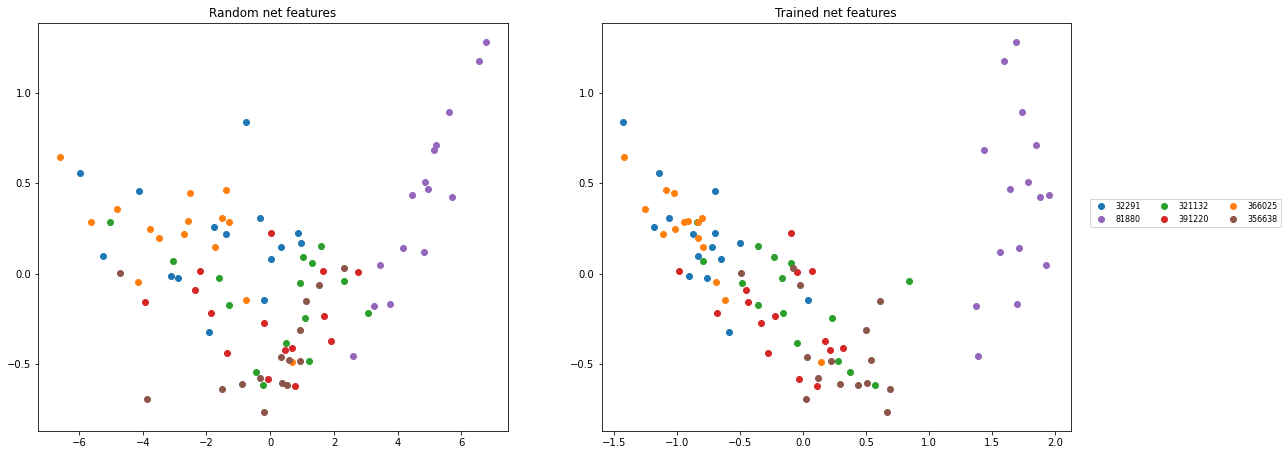

In [ ]:
#@title Plot the points
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
color_palette = mcolors.TABLEAU_COLORS if n_users <= 10 else mcolors.CSS4_COLORS
colors = list(color_palette)
color_vocab = { label:colors[i%len(colors)] for i,label in enumerate(set(ground_truth))}
xs = [ x[0] for x in data ]
xs_d = [ x[0] for x in p_data ]
ys = [ x[1] for x in data ]
l = []
lg = []
fig, axs = plt.subplots(1,2)
fig.set_size_inches(18.5, 7.5)
seen_labels = set()
for i in range(len(ground_truth)):
    o, = axs[1].plot(xs[i], ys[i], "o", color=color_palette[color_vocab[ground_truth[i]]])
    o_p, = axs[0].plot(xs_d[i], ys[i], "o", color=color_palette[color_vocab[ground_truth[i]]])
    if ground_truth[i] not in seen_labels:
        l.append(o)
        lg.append(ground_truth[i])
        seen_labels.add(ground_truth[i])
    #plt.text(xs[i], ys[i], ground_truth[i], fontsize=8)
axs[0].set_title("Random net features")
axs[1].set_title("Trained net features")
axs[1].legend(l,
           lg,
           loc=(1.04, 0.5),
           ncol=3,
           fontsize=8)
plt.show()

##5.2 Quantitative testing

In [ ]:
test_size : int = 1000 #@param{type:"integer"}
test_users = []
i = train_size + 1
# found the first test_size users not used in the training
while len(test_users) < test_size:
    if all_users[i] not in train_users or "keystroke" not in all_users[i]:
        test_users.append((all_users[i],False))
    i += 1

# stack all of them into a pandas dataframe TODO deal with manual
test_df = []
for user,manual in test_users:
    df = pd.read_csv(f"../../../data/Keystrokes_processed/{user}",
                 sep=",",
                 names = column_names,
                 header=None,
                 encoding = "ISO-8859-1",
                )
    test_df.append(df)

test_df : pd.DataFrame = pd.concat(test_df)
test_df.head(5)

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,TIMINGS
0,286689,3075839,Hence the importannce of the media bidding bat...,Hence the importannce of the media bidding bat...,"Any[(""SHIFT"", 16, 392, 0), (""72"", missing, 136..."
1,286689,3075934,My husband Jeff and I are planning on attending.,My husband Jeff and I are planning to attending.,"Any[(""SHIFT"", 16, 328, 0), (""77"", missing, 119..."
2,286689,3075921,He did not say when that would be.,He did not say that would be.,"Any[(""SHIFT"", 16, 568, 0), (""72"", missing, 104..."
3,286689,3075654,He extended Freudian theory into adolescence a...,He extended Freudian theory into adolescence a...,"Any[(""SHIFT"", 16, 256, 0), (""72"", missing, 128..."
4,286689,3075692,Louis defensive backs should be able to match ...,Louis defensive backs should be able to match ...,"Any[(""SHIFT"", 16, 1680, 0), (""76"", missing, 16..."


In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self,df : pd.DataFrame, vocab : Dict[str,int]):
        self.vocab = vocab
        self.data = df
        self.len = len(self.data)
    
    def __getitem__(self,idx : int) -> Dict[str,Any]:
        sample = self.data.iloc[idx]
        t = string_to_tensor(sample.TIMINGS, self.vocab)
        return { "label": sample.PARTICIPANT_ID, "timings": t, "lengths" : len(t) }
    
    def __len__(self) -> int:
        return self.len

def single_collate(batch : List[Dict[str,Any]]):
    batch_size = len(batch)
    batch_out = dict()
    batch_out["lengths"] = torch.zeros(batch_size)
    max_len = max([ b["lengths"] for b in batch])
    batch_out["timings"] = torch.zeros(batch_size,max_len,3)
    batch_out["labels"] = list()
    for i,sample in enumerate(batch):
        batch_out["lengths"][i] = sample["lengths"]
        batch_out["timings"][i,:sample["lengths"],:] = sample["timings"]
        batch_out["labels"].append(sample["label"])
    return batch_out
    
    



In [ ]:
test_set = TestDataset(test_df,char_vocab)
test_dl = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = False, collate_fn = single_collate)
next(iter(test_dl))

In [ ]:
ground_truth, data = df_to_features(test_df,char_vocab,pretrained_net,manual_data = False)

In [ ]:
len(data)